#hide
Copyright (c) 2022, Lorenzo Posti
All rights reserved.

This source code is licensed under the BSD-style license found in the
license_notebooks file in the root directory of this source tree. 

## Attribution & License

If you use parts of the code found in this notebook please cite the paper [Posti (2022), Res. Notes AAS, 6, 233](https://iopscience.iop.org/article/10.3847/2515-5172/aca0df).

Copyright (c) 2022, Lorenzo Posti.
The code is distributed under BSD-style license and it can be copied and used.

## Introduction

Galaxy rotation curves are usually modelled by assuming that each datapoint in the curve is independent from the others. However, this is naturally just a first order approximation, since observational effects such due to geometrical projection and resolution, as well as physical effects such as non-circular motions, can make the velocities measured in two adjacent annnuli significantly correlated.

In this notebook I use the rotation curve of NGC 2403 as a test case to show how to include Gaussian Processes (GPs) in rotation curve decomposition models, in order to account for underlying data correlations. More details can be found in the accompanying paper [Posti (2022), Res. Notes AAS, 6, 233](https://iopscience.iop.org/article/10.3847/2515-5172/aca0df).



In [1]:
#| code-fold: true
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import jax
import jax.numpy as jnp
import jaxopt
from functools import partial
from tinygp import GaussianProcess, kernels
import numpyro
import arviz
import corner

jax.config.update("jax_enable_x64", True)
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('text', usetex=True)

%config Completer.use_jedi = False
%matplotlib inline

## Data

Here I introduce the data for the galaxy NGC 2403 and the functions needed to work with Eq. (1) in the paper.

Note that the code below works also for any other galaxy whose data are formatted in the same way, e.g. it works with no modifications needed for all galaxies in the [SPARC](http://astroweb.cwru.edu/SPARC/) catalog [(Lelli et al. 2016)](https://ui.adsabs.harvard.edu/abs/2016AJ....152..157L/abstract).

### Definitions of functions for curve decomposition

I start with some definitions to specify $V_{\rm DM}(R)$, the contribution of DM to the circular velocity in Eq. (1).
I assume [NFW](https://ui.adsabs.harvard.edu/abs/1996ApJ...462..563N/abstract) profiles for the DM halos, which are specified by two parameters: halo mass $M_{\rm h}$ and concentration $c$. $M_{\rm h}$ is the virial mass defined with a critical overdensity of $\Delta_{\rm c}=200$.

In [4]:
G = 4.301e-9 # gravitational constant, in Mpc km^2 s^-2 Msun^-1
H = 70.      # Hubble's constant, in km s^-1 Mpc^-1
Dc= 200.     # critical overdensity

Note that below I use `jax`, and not `numpy`, to define these functions. This is needed in order to do model inference with `numpyro`.

In [5]:
# accessory function for NFW halos
def jax_fc(x): return jnp.log(1+x)-x/(1+x)

# definitions of virial velocity and virial radius
def jax_Vvir(Mh): return jnp.sqrt((Dc*(H)**2/2)**(1./3.) * (G*Mh)**(2./3.))
def jax_Rvir(Mh):
    rho_hat = 4. / 3. * np.pi * Dc * (3. * (H)**2 / (8. * np.pi * G))
    return 1e3 * ((Mh / rho_hat)**(1./3.))

# V_DM(R) for an NFW halo
def jax_vhalo(params, R):
    Mh, cc = 10**params['log_mh'], 10**params['log_c']    
    rv = jax_Rvir(Mh)
    return jnp.sqrt(jax_Vvir(Mh)**2*rv/R*jax_fc(cc*R/rv)/jax_fc(cc)) 

Finally, below I implement the model rotation curve in Eq. (1). Two things are worth pointing out:
- I use a linear interpolation for the baryonic part of the curve, since I assume that $V_{\rm gas}$ and $V_\star$ are measured at fixed radii, so that `params['r']`, `params['vg']` etc. are expected to be arrays of the same size.
- I decomposed $V_\star$ in the bulge and disk components, with two different mass-to-light ratios. While my test case NGC 2403 has no bulge, it is good to include it here for the sake of generality. The [SPARC](http://astroweb.cwru.edu/SPARC/) catalog indeed includes stellar circular velocities decomposed into bulge and disk.

In [6]:
def jax_vmod(params, R):
    return jnp.sqrt(jax_vhalo(params, R)**2 + # DM
                    jnp.interp(R, params['r'], params['vg']**2 + # gas
                               10**params['log_mld']*params['vd']**2+10**params['log_mlb']*params['vb']**2 # stars
                              ))

### Rotation curve data for NGC 2403

I take the rotation curve data of NGC 2403 from the [SPARC](http://astroweb.cwru.edu/SPARC/) catalog at face value. I include a copy of the file here for convenience. 

In [7]:
r, vobs, e_vobs, vg, vd, vb, _, _ = np.genfromtxt('data/NGC2403_rotmod.dat', unpack=True)

Let's plot the data below together with the best-fit model obtained by [Posti et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...626A..56P/abstract) for reference.

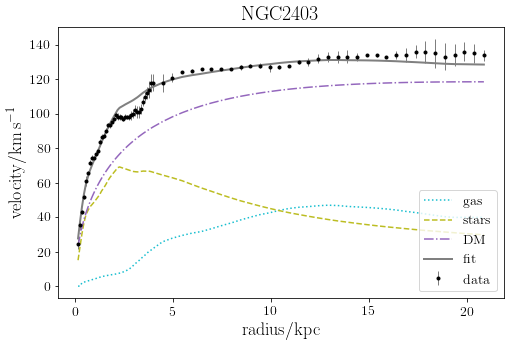

In [63]:
params = {
    # parameters of the best-fit in Posti et al. (2019)
    'log_mh' : 11.4,
    'log_c'  : 1.14,
    'log_mld': -0.377,
    'log_mlb': -99., # this galaxy has no bulge
    # data arrrays
    'r'  : r,
    'vg' : vg,
    'vd' : vd,
    'vb' : vb,
}

fig,ax = plt.subplots(figsize=(8,5))
ax.errorbar(r, vobs, yerr=e_vobs, fmt='.', c='k', lw=0.5, label=r'$\rm data$')
ax.plot(r, vg, ':', c='tab:cyan', label=r'$\rm gas$')
ax.plot(r, np.sqrt(10**params['log_mld']*vd**2+10**params['log_mlb']*vb**2), '--', c='tab:olive', label=r'$\rm stars$')
ax.plot(r, jax_vhalo(params, r), '-.', c='tab:purple', label=r'$\rm DM$')
ax.plot(r, jax_vmod(params, r), c='grey', lw=2, label=r'$\rm fit$')
ax.set_xlabel(r"$\rm radius/kpc$", fontsize=18)
ax.set_ylabel(r"$\rm velocity/km\,s^{-1}$", fontsize=18)
ax.set_title(r"$\rm NGC 2403$", fontsize=20);
ax.legend(loc='lower right', fontsize=14);
ax.tick_params(labelsize=14);

## Models with or without GPs

Let's now get to the modelling side of things. I set up two models here. The first one is analogous to [Posti et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...626A..56P/abstract), as well as many other works in this context (e.g. [Katz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466.1648K/abstract), [Li et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..247...31L/abstract), [Mancera-Pina et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.514.3329M/abstract), [di Teodoro et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv220702906D/abstract)), it has a $\chi^2$ likelihood and it implicitly assumes that the rotation curve datapoints are independent. The second one generalizes this model by using GPs to take into account data correlations. I recommend the recent review by [Aigrain & Foreman-Mackey (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220908940A/abstract), in particular their first section, as an introduction to GPs.

I use the library [`tinygp`](https://tinygp.readthedocs.io/en/stable/) to set up my GP regression problem and I use [`numpyro`](https://num.pyro.ai/en/stable/) to sample the posterior distribution. In particular, I use and Hamiltonian Monte Carlo sampler called *No U-Turn Sampler* (NUTS).

### Gaussian Processes

Let's generate GPs with an `Exp-Squared` kernel with two parameters, an amplitude $A_k$ and a scale $s_k$, i.e.
$$
k(R_i, R_j) = A_k \exp\left[-\frac{1}{2}\left(\frac{|R_i-R_j|}{s_k}\right)^2\right]
$$
This kernel is said to be *stationary* because it depends only on the distance between two points $|R_i-R_j|$.

In [17]:
def build_gp(params, x, yerr):
    kernel = 10**params['log_amp']*kernels.ExpSquared(10**params['log_scl'], distance=kernels.distance.L1Distance())
    return GaussianProcess(kernel, 
                           x, 
                           diag=yerr**2, 
                           mean=partial(jax_vmod, params)
                          )

### `numpyro` models

I now set up the model's posterior distribution to be sampled by `numpyro`, thus it is a function containing `pyro` primitives.

The model starts by defining the priors on the physical parameters ($\theta_V$ in the paper). I use:
- uninformative prior on $\log\,M_{\rm h}$
- Gaussian on $\log\,c$, with mean and width following the $c-M_{\rm h}$ relation found in cosmological simulations [(Dutton & Maccio' 2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.441.3359D/abstract)
- Gaussian on $\log\,(M/L)_{\rm D}$, centred on $(M/L)_{\rm D}=0.5$ and with standard deviation of 0.2 dex (compatible with stellar population synthesis models, e.g. [Lelli et al. 2016](https://ui.adsabs.harvard.edu/abs/2016AJ....152..157L/abstract)) 
- Gaussian on $\log\,(M/L)_{\rm B}$, centred on $(M/L)_{\rm B}=0.7$ and with standard deviation of 0.2 dex (again, see [Lelli et al. 2016](https://ui.adsabs.harvard.edu/abs/2016AJ....152..157L/abstract)). Note that *this is not used* in the case of NGC 2403 

After the definition of the priors the function branches out: one branch with GPs and one without. I borrowed this structure from the [transit example](https://github.com/dfm/araa-gps/blob/main/src/scripts/transit.ipynb) of Fig. 3 in [Aigrain & Foreman-Mackey (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220908940A/abstract).

The branch with GP also implement additional priors for the two parameters of the kernel ($\theta_k$ in the paper), i.e. the amplitude and scale.

In [18]:
def model(t, y_err, y, params, use_gp=False):
    
    # priors
    params["log_mh"]=numpyro.sample("log_mh",numpyro.distributions.Uniform(8.0,  14.0)) 
    params["log_c"] =numpyro.sample('log_c',numpyro.distributions.Normal(0.905-0.101*(params['log_mh']*0.7-12),0.11)) 
    params["log_mld"]=numpyro.sample('log_mld',numpyro.distributions.Normal(-0.3, 0.2)) 
    params["log_mlb"]=numpyro.sample('log_mlb',numpyro.distributions.Normal(-0.15, 0.2)) 
    
    if use_gp:
        ###################
        # branch WITH GPs #
        ###################
        
        # define kernel parameters
        params["log_amp"] = numpyro.sample("log_amp", numpyro.distributions.Uniform(-4.0, 5.0))
        params["log_scl"] = numpyro.sample("log_scl", numpyro.distributions.Uniform(-2.0, 3.0))
        
        # generate the GP
        gp = build_gp(params, t, y_err)
        
        # sample the posterior
        numpyro.sample("y", gp.numpyro_dist(), obs=y)
        
        # calculate the predicted V_rot (i.e. the mean function) of the model
        mu = gp.mean_function(params["r_grid"])
        numpyro.deterministic("mu", mu)

    else:
        ######################
        # branch WITHOUT GPs #
        ######################
        
        # sample the posterior
        numpyro.sample("y", numpyro.distributions.Normal(jax_vmod(params, t), y_err), obs=y)
        
        # calculate properties of the model
        numpyro.deterministic("mu", jax_vmod(params, params["r_grid"]))

### Running the model without GP, i.e. assuming independent datapoints

I start by sampling the posterior of the model akin to that of [Posti et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...626A..56P/abstract), i.e. assuming that the points in the curve are independent.

I'm using [`arviz`](https://arviz-devs.github.io/arviz/) to analyse the posterior sampled by NUTS. In particular, keep an eye on `r_hat` which is the Gelman-Rubin statistics: for our purposes, we can use ${\rm r_{hat}}\simeq 1$ as an indicator that the marginalized posterior on a particular parameter is well determined.

In [55]:
grid_size = 1000
r_grid = jnp.linspace(r.min(), r.max(), grid_size) # radial grid on which to predict V_rot(R)
params = {"vg"    : vg,
          "vd"    : vd,
          "vb"    : vb,
          "r"     : r,
          "r_grid": r_grid}

In [51]:
num_warmup=1000
num_samples=3000
num_chains=3
accept_prob = 0.9

sampler_wn = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        target_accept_prob=accept_prob,
    ),
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), r, e_vobs, vobs, params)

inf_data_wn = arviz.from_numpyro(sampler_wn)
arviz.summary(inf_data_wn, var_names=["log_mh", "log_c", "log_mld"])

sample: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:13<00:00, 288.30it/s, 15 steps of size 1.95e-01. acc. prob=0.95]


CPU times: user 43.9 s, sys: 807 ms, total: 44.7 s
Wall time: 45.7 s


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_mh,11.325,0.014,11.298,11.351,0.000,0.000,3623.0,4045.0,1.0
log_c,1.234,0.019,1.198,1.268,0.000,0.000,3382.0,3801.0,1.0
log_mld,-0.542,0.045,-0.632,-0.463,0.001,0.001,3267.0,3282.0,1.0


Let's plot the chains to make sure each parameter is converged

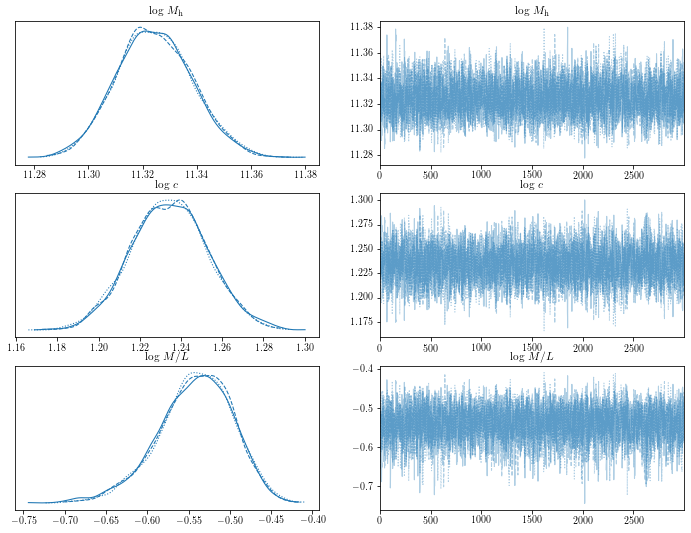

In [48]:
azLabeller = arviz.labels.MapLabeller(var_name_map={"log_mh" : r"$\log\,M_{\rm h}$",
                                                    "log_c"  : r"$\log\,c$", 
                                                    "log_mld": r"$\log\,M/L$",
                                                    "log_amp": r"$A_k$",
                                                    "log_scl": r"$s_k$"})
arviz.plot_trace(inf_data_wn, var_names=["log_mh", "log_c", "log_mld"], figsize=(12,9), 
                 labeller = azLabeller);

### Running the model with GP, i.e. taking into account data correlations

Now, let's have a look at what happens when GPs come into play. I run exactly the same procedure as before to sample the model's posterior, but this time I select the branch with `use_gp=True`. Since now I have two more free parameters, the scale and amplitude of the kernel, I also initialize these two in `init_strategy`.

In [41]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        target_accept_prob=accept_prob,
    ),
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(11), r, e_vobs, vobs, params, use_gp=True)

inf_data = arviz.from_numpyro(sampler)
arviz.summary(inf_data, var_names=["log_mh", "log_c", "log_mld", "log_amp", "log_scl"])

sample: 100%|████████████████████████████████████████████████████████████████████| 4000/4000 [00:25<00:00, 159.04it/s, 7 steps of size 4.01e-01. acc. prob=0.94]


CPU times: user 2min 27s, sys: 2.85 s, total: 2min 30s
Wall time: 1min 38s


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_mh,11.491,0.076,11.353,11.642,0.001,0.001,5466.0,4897.0,1.0
log_c,1.079,0.065,0.956,1.201,0.001,0.001,5602.0,4905.0,1.0
log_mld,-0.326,0.075,-0.470,-0.191,0.001,0.001,5531.0,4435.0,1.0
log_amp,1.104,0.270,0.624,1.602,0.005,0.004,3793.0,3277.0,1.0
log_scl,-0.018,0.087,-0.188,0.131,0.001,0.001,3788.0,3652.0,1.0


And let's plot again the chains to make sure that every parameter has converged

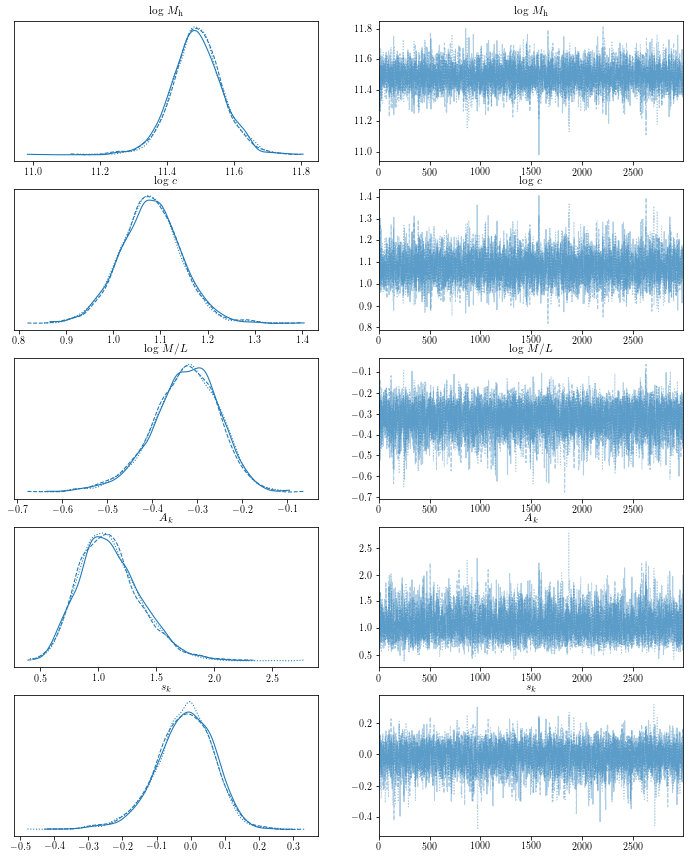

In [49]:
arviz.plot_trace(inf_data, var_names=["log_mh", "log_c", "log_mld", "log_amp", "log_scl"], figsize=(12,15), 
                 labeller = azLabeller);

Everything looks good for both models.

### Comparing the predictions of the two models

Finally, I can compare the posterior distributions of the two models. I use [corner](https://corner.readthedocs.io/en/latest/) to plot 1-D and 2-D projections of the posteriors.

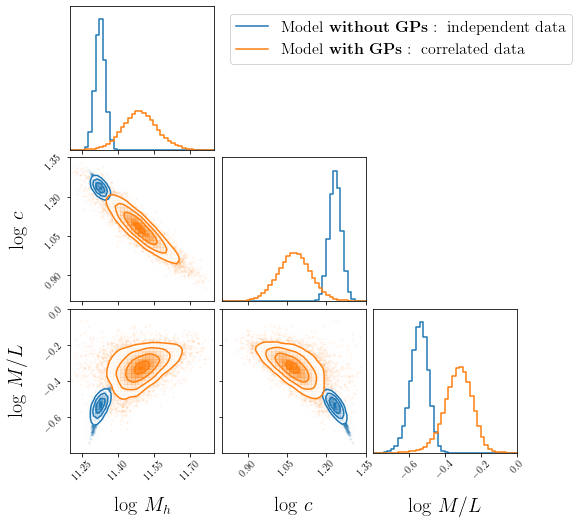

In [75]:
ranges = [(11.2, 11.8), (0.8, 1.35), (-0.8,-0.0)] # NGC 2403

fig = corner.corner(inf_data_wn, bins=40, range=ranges, 
                    color="C0", var_names=["log_mh", "log_c", "log_mld"], smooth=1.0, smooth1d=1.0
                   )
fig = corner.corner(inf_data, bins=40, range=ranges, 
                    color="C1", var_names=["log_mh", "log_c", "log_mld"], smooth=1.0, smooth1d=1.0,
                    labels=["$\log\,M_h$", "$\log\,c$", r"$\log\,M/L$"],
                    label_kwargs={"fontsize":20}, fig=fig)


# make legend
ax = fig.axes[1]
key_nn = matplotlib.lines.Line2D([], [], color='C0',    linestyle='-', 
                                 label=r'$\rm Model\,\,{\bf without\,\,GPs}:\,\,independent\,\,data$')
key_gp = matplotlib.lines.Line2D([], [], color='C1',   linestyle='-', 
                                 label=r'$\rm Model\,\,{\bf with\,\,GPs}:\,\,correlated\,\,data$')
ax.legend(loc='upper left', handles=[key_nn, key_gp], fontsize=16);

Then I can compare the predicted curve decompositions of the two models.
Here I get the predictions of the model, excluding the warmup phase during sampling.

In [56]:
final_shape = (num_chains*(num_samples-num_warmup),grid_size) # shape of the predictions array after removing warmup

pred_wn = sampler_wn.get_samples(group_by_chain=True)['mu'][:,num_warmup:,:].reshape(final_shape)
pred    = sampler.get_samples(group_by_chain=True)['mu'][:,num_warmup:,:].reshape(final_shape)

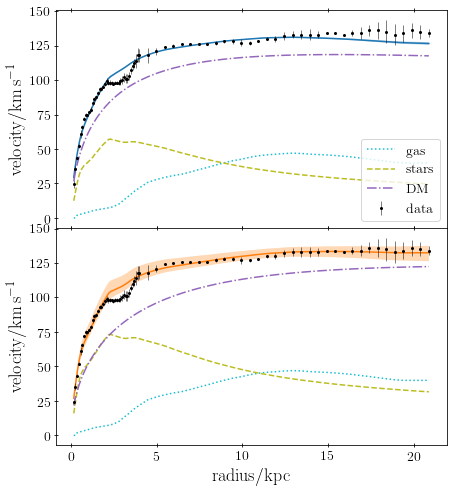

In [79]:
fig,ax = plt.subplots(figsize=(7,8), nrows=2, gridspec_kw={'hspace':0})

def commons(ax, i, lmh, lc, lmld, lmlb, leg=True):
    # rotation curve
    ax[i].errorbar(r, vobs, yerr=e_vobs, fmt='.', c='k', lw=0.5, label=r'$\rm data$', markersize=4)
    ax[i].plot(r, vg, ':', c='tab:cyan', label=r'$\rm gas$')
    ax[i].plot(r, np.sqrt(10**lmld*vd**2+10**lmlb*vb**2), '--', c='tab:olive', label=r'$\rm stars$')
    ax[i].plot(r, jax_vhalo({'log_mh':lmh, 'log_c':lc}, r), '-.', c='tab:purple', label=r'$\rm DM$')
    if leg: ax[i].legend(loc='lower right', fontsize=14)
    ax[i].set_xlabel(r"$\rm radius/kpc$", fontsize=18)
    ax[i].set_ylabel(r"$\rm velocity/km\,s^{-1}$", fontsize=18)
    ax[i].tick_params(direction='inout', top=True, labelsize=14)
    
    
ax[0].fill_between(r_grid, np.percentile(pred_wn,2.1,axis=0), np.percentile(pred_wn,97.9,axis=0), 
                     facecolor='C0', alpha=0.3)
ax[1].fill_between(r_grid, np.percentile(pred,2.1,axis=0), np.percentile(pred,97.9,axis=0), 
                     facecolor='C1', alpha=0.3)
ax[0].plot(r_grid, np.median(pred_wn, axis=0), 'C0')
ax[1].plot(r_grid, np.median(pred, axis=0), 'C1')
commons(ax, 0, 11.325, 1.234, -0.542, -99.)
commons(ax, 1, 11.491, 1.079, -0.326, -99., leg=False)

### Correlation matrix

Given that the parameters of the kernel $A_k$ and $s_k$ are well constrained by the model, we can have a look at the correlation matrix of the model with GPs.

In [64]:
%%time
def get_kmat(params, x, yerr,):
    gp = build_gp(params, x, yerr)

    xm1, xm2 = jnp.meshgrid(x,x)
    zm = np.zeros_like(xm1.flatten())
    for i in range(len(xm1.flatten())):
        zm[i]=gp.kernel.evaluate(xm1.flatten()[i], xm2.flatten()[i])

    return zm.reshape((len(x), len(x)))

zm = get_kmat({"log_amp":1.104, "log_scl":-0.018, 'log_mh':11.325, 'log_c':1.234, 
               'log_mld':-0.542, 'log_mlb':-99., 'vg':vg, 'vd':vd, 'vb':vb, 'r':r}, r, e_vobs)

CPU times: user 1min 35s, sys: 2.17 s, total: 1min 37s
Wall time: 2min


In [65]:
def plt_mat(ax, zm):
    
    im=ax.matshow(zm)
    ax.set_xlabel("$i$", fontsize=20)
    ax.set_ylabel("$j$", fontsize=20)
    ax.tick_params(labelsize=14)
    ax.xaxis.set_label_position('top') 
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$k(R_i, R_j)$", fontsize=22)
    cb.ax.tick_params(labelsize=16)

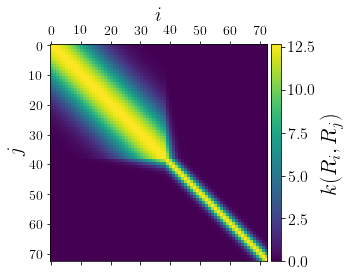

In [67]:
fig,ax = plt.subplots()
plt_mat(ax, zm)

The peculiar 2-block shape of this matrix is due to the combined H$\alpha$-HI nature of the rotation curve. The optical H$\alpha$ curve samples the inner regions of the galaxy, up to $\sim 5$ kpc, with a finer spatial sampling of 0.1 kpc with respect to the HI rotation curve, which instead has a spacing of 0.5 kpc and is from 5 kpc outwards.